### Réduction de dimensions

L'objectif de ce notebook est de tester les algos de réduction de dimensions

In [1]:
from sklearn.feature_selection import VarianceThreshold, SelectKBest, SelectFromModel, f_regression, mutual_info_regression, RFE, RFECV
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline

In [2]:
df = pd.read_csv('databases/inter/03C - dvf_merged_2020.csv')
df.columns

C:\Users\olivier\anaconda\envs\py39\lib\site-packages\IPython\core\interactiveshell.py:3441: DtypeWarning: Columns (8,18,20,22,35) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


Index(['Unnamed: 0', 'No disposition', 'Date mutation', 'Nature mutation',
       'Valeur fonciere', 'No voie', 'B/T/Q', 'Type de voie', 'Code voie',
       'Voie', 'Code postal', 'Commune', 'Code departement', 'Code commune',
       'Prefixe de section', 'Section', 'No plan', 'No Volume', '1er lot',
       'Surface Carrez du 1er lot', '2eme lot', 'Surface Carrez du 2eme lot',
       '3eme lot', 'Surface Carrez du 3eme lot', '4eme lot',
       'Surface Carrez du 4eme lot', '5eme lot', 'Surface Carrez du 5eme lot',
       'Nombre de lots', 'Code type local', 'Type local', 'Identifiant local',
       'Surface reelle bati', 'Nombre pieces principales', 'Nature culture',
       'Nature culture speciale', 'Surface terrain', 'Code commune INSEE',
       'Ville', 'Adresse', 'Prix m2', 'Paris', 'dep_name', 'region_name',
       'Mer', 'Commune_Lat', 'Commune_Lon', 'lon', 'lat',
       'Code postal 5 chiffres', 'code_iris_clean', 'Alimentation', 'Aéroport',
       'Baignade', 'Banques', 'Boulan

### Ajout des prix moyens au m² par quartier et par commune

In [3]:
pd.set_option('display.max_columns', None)
df['code_iris_clean'] = df['code_iris_clean'].fillna(-1).astype(int).astype(str).replace('-1', np.nan)
df.head()

,Unnamed: 0,No disposition,Date mutation,Nature mutation,Valeur fonciere,No voie,B/T/Q,Type de voie,Code voie,Voie,Code postal,Commune,Code departement,Code commune,Prefixe de section,Section,No plan,No Volume,1er lot,Surface Carrez du 1er lot,2eme lot,Surface Carrez du 2eme lot,3eme lot,Surface Carrez du 3eme lot,4eme lot,Surface Carrez du 4eme lot,5eme lot,Surface Carrez du 5eme lot,Nombre de lots,Code type local,Type local,Identifiant local,Surface reelle bati,Nombre pieces principales,Nature culture,Nature culture speciale,Surface terrain,Code commune INSEE,Ville,Adresse,Prix m2,Paris,dep_name,region_name,Mer,Commune_Lat,Commune_Lon,lon,lat,Code postal 5 chiffres,code_iris_clean,Alimentation,Aéroport,Baignade,Banques,Boulangerie,Camping,Cinéma,Collège ou lycée,Crèche,Ecole mat et primaire,Ecole sup,Etab hospi,Gare,Gare nationale,Hotels,Info touristique,Parcours sportif/santé,Pharmacie,Police ou gendarmerie,Port plaisance,Restaurants,Resto U,Résidence U,Salle multisport,loyer,Population totale,SNHMO18,SNHMFO18,dep,anciennete,consommation_energie,classe_consommation_energie,estimation_ges,classe_estimation_ges,surface_baies_orientees_sud
0,0,1,09/01/2020,Vente,72000.0,5367.0,NaN,NaN,B107,LORETTE,1270.0,COLIGNY,1,108,NaN,AH,48,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1.0,Maison,NaN,35.0,2.0,S,NaN,381.0,1108,1270 COLIGNY,5367 LORETTE 1270 COLIGNY,2057.142857,0,Ain,Auvergne-Rhône-Alpes,0,46.386664,5.330823,5.351500,46.380469,1270.0,11080000,1.0,0.0,0.0,2.0,2.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,4.0,0.0,0.0,1.0,NaN,NaN,11.531505,10.275121,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,1,06/01/2020,Vente,180300.0,31.0,NaN,RUE,0970,COMTE DE LA TEYSSONNIERE,1000.0,BOURG-EN-BRESSE,1,53,NaN,AI,138,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1.0,Maison,NaN,75.0,4.0,S,NaN,525.0,1053,1000 BOURG EN BRESSE,31 RUE COMTE DE LA TEYSSONNIERE 1000 BOURG EN ...,2404.000000,0,Ain,Auvergne-Rhône-Alpes,0,46.205152,5.246021,5.208966,46.197026,1000.0,10530203,1.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,1.0,NaN,NaN,11.531505,10.275121,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,1,06/01/2020,Vente,54800.0,6.0,NaN,AV,0770,DU CHAMP DE FOIRE,1000.0,BOURG-EN-BRESSE,1,53,NaN,BK,197,NaN,211,31.68,39.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,2.0,Appartement,NaN,32.0,1.0,NaN,NaN,0.0,1053,1000 BOURG EN BRESSE,6 AV DU CHAMP DE FOIRE 1000 BOURG EN BRESSE,1712.500000,0,Ain,Auvergne-Rhône-Alpes,0,46.205152,5.246021,5.229923,46.206965,1000.0,10530101,3.0,0.0,0.0,15.0,9.0,0.0,1.0,1.0,2.0,3.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,4.0,1.0,0.0,69.0,0.0,0.0,0.0,NaN,NaN,11.531505,10.275121,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,1,13/01/2020,Vente,97000.0,16.0,NaN,RUE,1770,DES GRAVES,1000.0,BOURG-EN-BRESSE,1,53,NaN,AZ,476,NaN,8,78.03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,2.0,Appartement,NaN,92.0,3.0,NaN,NaN,0.0,1053,1000 BOURG EN BRESSE,16 RUE DES GRAVES 1000 BOURG EN BRESSE,1054.347826,0,Ain,Auvergne-Rhône-Alpes,0,46.205152,5.246021,5.232291,46.199495,1000.0,10530302,2.0,0.0,0.0,2.0,2.0,0.0,0.0,4.0,1.0,2.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,2.0,0.0,0.0,13.0,0.0,0.0,4.0,NaN,NaN,11.531505,10.275121,1.0,42.0,267.37,E,7.22,B,0.0
4,4,1,09/01/2020,Vente,215000.0,2.0,NaN,IMP,0140,DU COLOMBIER,1250.0,TOSSIAT,1,422,NaN,D,1121,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1.0,Maison,NaN,93.0,4.0,S,NaN,790.0,1422,1250 TOSSIAT,2 IMP DU COLOMBIER 1250 TOSSIAT,2311.827957,0,Ain,Auvergne-Rhône-Alpes,0,46.138479,5.304001,5.311045,46.141154,1250.0,14220000,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,6.0,0.0,0.0,0.0,NaN,NaN,11.531505,10.275121,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
# Calcul du prix moyen au m² par commune, type local et nb pièces
df_prix_commune = df.groupby(['Code postal', 'Commune', 'Type local'])['Prix m2'].median()
df = df.merge(df_prix_commune, how = "left", on = ['Code postal', 'Commune', 'Type local']).rename(columns = {
        'Prix m2_x': 'Prix m2', 
        'Prix m2_y': 'prix m2 commune'})

# Calcul du prix moyen au m² par proximité GPS et type
df['lon_2'] = df['lon'].apply(lambda x: round(x, 2))     # On arrondit la longitude à 2 décimales afin de regrouper les biens par carré de 700m x 700m environ
df['lat_2'] = df['lat'].apply(lambda x: round(x, 2))     # Pareil pour latitude

df_prix_gps = df.groupby(['lon_2', 'lat_2', 'Type local'])['Prix m2'].median()
df = df.merge(df_prix_gps, how = "left", on = ['lon_2', 'lat_2', 'Type local']).rename(columns = {
        'Prix m2_x': 'Prix m2', 
        'Prix m2_y': 'prix m2 gps'})

In [5]:
# Suppression des colonnes inutiles
df = df.drop(columns = {'Unnamed: 0', 'Date mutation', 'Surface terrain', 'lon', 'lat', 'Type de voie', 
                        'Commune', 'Code departement', 'Nombre de lots', 'Code commune INSEE', 
                        'Adresse', 'dep_name', 'region_name', 'Code postal 5 chiffres', 'code_iris_clean', 
                        'Prix m2', 'No disposition', 'Nature mutation', 'No voie', 'B/T/Q', 'Code voie', 'Voie', 
                        'Code postal', 'Code commune', 'Prefixe de section', 'Section', 'No plan', 'No Volume', '1er lot',
                        'Surface Carrez du 1er lot', '2eme lot', 'Surface Carrez du 2eme lot',
                        '3eme lot', 'Surface Carrez du 3eme lot', '4eme lot',
                        'Surface Carrez du 4eme lot', '5eme lot', 'Surface Carrez du 5eme lot',
                        'Code type local', 'Identifiant local', 'Nature culture', 'Nature culture speciale', 'Ville',
                        'classe_consommation_energie', 'classe_estimation_ges', 'lon_2', 'lat_2', 'dep', 'Commune_Lat', 'Commune_Lon'})  

df.columns

Index(['Valeur fonciere', 'Type local', 'Surface reelle bati',
       'Nombre pieces principales', 'Paris', 'Mer', 'Alimentation', 'Aéroport',
       'Baignade', 'Banques', 'Boulangerie', 'Camping', 'Cinéma',
       'Collège ou lycée', 'Crèche', 'Ecole mat et primaire', 'Ecole sup',
       'Etab hospi', 'Gare', 'Gare nationale', 'Hotels', 'Info touristique',
       'Parcours sportif/santé', 'Pharmacie', 'Police ou gendarmerie',
       'Port plaisance', 'Restaurants', 'Resto U', 'Résidence U',
       'Salle multisport', 'loyer', 'Population totale', 'SNHMO18', 'SNHMFO18',
       'anciennete', 'consommation_energie', 'estimation_ges',
       'surface_baies_orientees_sud', 'prix m2 commune', 'prix m2 gps'],
      dtype='object')

In [6]:
df['Type local'] = df.apply(lambda x: 1 if x['Type local'] == "Maison" else 0, axis = 1)
df.head()

,Valeur fonciere,Type local,Surface reelle bati,Nombre pieces principales,Paris,Mer,Alimentation,Aéroport,Baignade,Banques,Boulangerie,Camping,Cinéma,Collège ou lycée,Crèche,Ecole mat et primaire,Ecole sup,Etab hospi,Gare,Gare nationale,Hotels,Info touristique,Parcours sportif/santé,Pharmacie,Police ou gendarmerie,Port plaisance,Restaurants,Resto U,Résidence U,Salle multisport,loyer,Population totale,SNHMO18,SNHMFO18,anciennete,consommation_energie,estimation_ges,surface_baies_orientees_sud,prix m2 commune,prix m2 gps
0,72000.0,1,35.0,2.0,0,0,1.0,0.0,0.0,2.0,2.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,4.0,0.0,0.0,1.0,NaN,NaN,11.531505,10.275121,NaN,NaN,NaN,NaN,1259.259259,1269.775615
1,180300.0,1,75.0,4.0,0,0,1.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,1.0,NaN,NaN,11.531505,10.275121,NaN,NaN,NaN,NaN,1918.367347,2140.612903
2,54800.0,0,32.0,1.0,0,0,3.0,0.0,0.0,15.0,9.0,0.0,1.0,1.0,2.0,3.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,4.0,1.0,0.0,69.0,0.0,0.0,0.0,NaN,NaN,11.531505,10.275121,NaN,NaN,NaN,NaN,1543.040293,1500.000000
3,97000.0,0,92.0,3.0,0,0,2.0,0.0,0.0,2.0,2.0,0.0,0.0,4.0,1.0,2.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,2.0,0.0,0.0,13.0,0.0,0.0,4.0,NaN,NaN,11.531505,10.275121,42.0,267.37,7.22,0.0,1543.040293,1547.809524
4,215000.0,1,93.0,4.0,0,0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,6.0,0.0,0.0,0.0,NaN,NaN,11.531505,10.275121,NaN,NaN,NaN,NaN,1623.076923,1828.007002


In [7]:
# Test en réduisant au max le nb de features
#df = df[['Valeur fonciere', 'Surface reelle bati', 'Nombre pieces principales', 'loy_appart', 'prix m2 quartier', 
#        'Hotels', 'Info touristique', 'Crèche', 'DISP_Q318']]

In [8]:
df.dtypes

Valeur fonciere                float64
Type local                       int64
Surface reelle bati            float64
Nombre pieces principales      float64
Paris                            int64
Mer                              int64
Alimentation                   float64
Aéroport                       float64
Baignade                       float64
Banques                        float64
Boulangerie                    float64
Camping                        float64
Cinéma                         float64
Collège ou lycée               float64
Crèche                         float64
Ecole mat et primaire          float64
Ecole sup                      float64
Etab hospi                     float64
Gare                           float64
Gare nationale                 float64
Hotels                         float64
Info touristique               float64
Parcours sportif/santé         float64
Pharmacie                      float64
Police ou gendarmerie          float64
Port plaisance           

In [9]:
df.describe()

,Valeur fonciere,Type local,Surface reelle bati,Nombre pieces principales,Paris,Mer,Alimentation,Aéroport,Baignade,Banques,Boulangerie,Camping,Cinéma,Collège ou lycée,Crèche,Ecole mat et primaire,Ecole sup,Etab hospi,Gare,Gare nationale,Hotels,Info touristique,Parcours sportif/santé,Pharmacie,Police ou gendarmerie,Port plaisance,Restaurants,Resto U,Résidence U,Salle multisport,loyer,Population totale,SNHMO18,SNHMFO18,anciennete,consommation_energie,estimation_ges,surface_baies_orientees_sud,prix m2 commune,prix m2 gps
count,5.016790e+05,501679.000000,501679.000000,501679.000000,501679.000000,501679.000000,467340.000000,467340.000000,467340.000000,467340.000000,467340.000000,467340.000000,467340.000000,467340.000000,467340.000000,467340.000000,467340.000000,467340.000000,467340.000000,467340.000000,467340.000000,467340.000000,467340.000000,467340.000000,467340.000000,467340.000000,467340.000000,467340.000000,467340.000000,467340.000000,469601.000000,469601.000000,501679.000000,501679.000000,248611.000000,248611.000000,248611.000000,218961.000000,501665.000000,487914.000000
mean,2.302785e+05,0.516167,78.184058,3.469340,0.035592,0.155129,2.658459,0.002754,0.070912,2.086290,2.613012,0.400770,0.142284,0.608407,0.580577,1.686900,0.081320,0.212233,0.115150,0.008737,1.123970,0.545695,0.078027,1.314591,0.157513,0.040296,16.576518,0.020811,0.037330,0.572438,11.922771,47482.389933,11.411342,10.106458,52.178520,206.055437,27.316730,1.588713,3155.441939,3180.616652
std,1.717911e+05,0.499739,36.995283,1.484096,0.185272,0.362028,3.197414,0.052405,0.427317,3.113738,3.064324,1.771373,0.375377,1.009534,0.826868,1.289039,0.514521,0.759013,0.336664,0.093885,2.744433,0.989775,0.277669,1.395712,0.382585,0.265187,27.628970,0.172173,0.260939,0.758464,5.205343,73240.896607,0.406255,0.328005,27.159895,1508.671373,413.337314,6.028264,2080.847557,2141.532238
min,4.252000e+04,0.000000,10.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.896745,16.000000,10.457648,9.217102,0.000000,-106.000000,-20.000000,0.000000,994.382022,994.382022
25%,1.250000e+05,0.000000,52.000000,2.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000,0.000000,0.000000,0.000000,8.340742,4322.000000,11.110637,9.859596,32.000000,134.000000,7.570000,0.000000,1829.931193,1819.569531
50%,1.825000e+05,1.000000,74.000000,3.000000,0.000000,0.000000,2.000000,0.000000,0.000000,1.000000,2.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,8.000000,0.000000,0.000000,0.000000,10.827580,16809.000000,11.348525,10.111371,50.000000,202.000000,17.000000,0.000000,2580.645161,2582.231656
75%,2.790000e+05,1.000000,97.000000,4.000000,0.000000,0.000000,4.000000,0.000000,0.000000,3.000000,3.000000,0.000000,0.000000,1.000000,1.000000,2.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,2.000000,0.000000,0.000000,17.000000,0.000000,0.000000,1.000000,13.733377,54207.000000,11.630620,10.307206,74.000000,268.490000,41.290000,0.000000,3710.084034,3749.023199
max,2.021400e+06,1.000000,293.000000,109.000000,1.000000,1.000000,50.000000,1.000000,8.000000,39.000000,31.000000,50.000000,5.000000,9.000000,10.000000,12.000000,19.000000,13.000000,5.000000,2.000000,57.000000,23.000000,2.000000,12.000000,3.000000,9.000000,296.000000,6.000000,8.000000,7.000000,36.654438,491942.000000,12.771537,10.910816,221.000000,684622.000000,205386.000000,517.590000,17500.000000,18405.590278


In [10]:
df = df.dropna()
df.shape

(198299, 40)

In [11]:
target = df['Valeur fonciere']
df = df.drop(columns = {'Valeur fonciere'})
df.shape

(198299, 39)

In [12]:
X_train, X_test, y_train, y_test = train_test_split(df, target, test_size = 0.2, random_state = 1234)

## Score régression avant standardisation et réduction de dimensions

In [13]:
lr = LinearRegression()
lr.fit(X_train, y_train)

# Score R2 du modèle d'apprentissage
print('Coefficient de détermination du modèle :', lr.score(X_train, y_train))

# Score R2 sur le jeu de test
print('Score sur le jeu de test :', lr.score(X_test, y_test))

lr_pred_train = lr.predict(X_train) 
lr_pred_test = lr.predict(X_test) 
print('rmse train :', mean_squared_error(lr_pred_train, y_train, squared=False)) 
print('rmse test :', mean_squared_error(lr_pred_test, y_test, squared=False))

print("mae train : ", mean_absolute_error(lr_pred_train, y_train))
print('mae test :', mean_absolute_error(lr_pred_test, y_test))

Coefficient de détermination du modèle : 0.7210236380696264
Score sur le jeu de test : 0.718839306913178
rmse train : 94885.75359766716
rmse test : 95302.6386982645
mae train :  57491.112865034156
mae test : 57507.85895829892


In [14]:
X_train_save = X_train
X_test_save = X_test

#### Standardisation avant réduction de dimensions

In [15]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [16]:
df.columns

Index(['Type local', 'Surface reelle bati', 'Nombre pieces principales',
       'Paris', 'Mer', 'Alimentation', 'Aéroport', 'Baignade', 'Banques',
       'Boulangerie', 'Camping', 'Cinéma', 'Collège ou lycée', 'Crèche',
       'Ecole mat et primaire', 'Ecole sup', 'Etab hospi', 'Gare',
       'Gare nationale', 'Hotels', 'Info touristique',
       'Parcours sportif/santé', 'Pharmacie', 'Police ou gendarmerie',
       'Port plaisance', 'Restaurants', 'Resto U', 'Résidence U',
       'Salle multisport', 'loyer', 'Population totale', 'SNHMO18', 'SNHMFO18',
       'anciennete', 'consommation_energie', 'estimation_ges',
       'surface_baies_orientees_sud', 'prix m2 commune', 'prix m2 gps'],
      dtype='object')

## Test SelectKBest

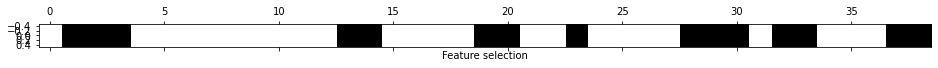

In [17]:
sel = SelectKBest(score_func = f_regression, k = 15)
sel.fit(X_train, y_train)

mask = sel.get_support()
plt.matshow(mask.reshape(1,-1), cmap = 'gray_r')
plt.xlabel('Feature selection');

=> Les 15 features les + importantes d'après ce test : Surface, Nb pièces, Paris (yes/no), Nb crèches du quartier, Nb écoles mat et primaire, Nb Hotels, Nb Info touristique, Nb Salle multisport, Nb Police ou gendarmerie, Loyer, Population, SNHMFO18, dep, Population totale, Ancienneté du bien, Prix m² commune, Prix m² GPS

In [18]:
X_train_sel = sel.fit_transform(X_train, y_train)
X_test_sel = sel.transform(X_test)

lr = LinearRegression()
lr.fit(X_train_sel, y_train)

# Score R2 du modèle d'apprentissage
print('Coefficient de détermination du modèle :', lr.score(X_train_sel, y_train))

# Score R2 sur le jeu de test
print('Score sur le jeu de test :', lr.score(X_test_sel, y_test))

lr_pred_train = lr.predict(X_train_sel) 
lr_pred_test = lr.predict(X_test_sel) 
print('rmse train :', mean_squared_error(lr_pred_train, y_train, squared=False)) 
print('rmse test :', mean_squared_error(lr_pred_test, y_test, squared=False))

print("mae train : ", mean_absolute_error(lr_pred_train, y_train))
print('mae test :', mean_absolute_error(lr_pred_test, y_test))

Coefficient de détermination du modèle : 0.7191574033805894
Score sur le jeu de test : 0.720505988928517
rmse train : 95202.59751212099
rmse test : 95019.74835766989
mae train :  57680.031035393265
mae test : 57597.33051033661


Le fait de ne conserver que 15 features ne fait pas bcp augmenter l'erreur

## Test RFE

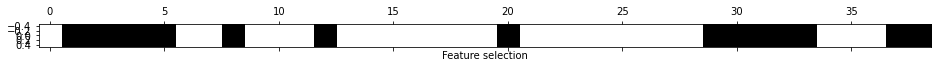

In [19]:
# Instanciation de l'algo RFE (Recursive Feature Elimination)
lm = LinearRegression()
rfe = RFE(estimator = lm, step = 1, n_features_to_select = 15)
rfe.fit(X_train, y_train)

# Identification des features conservées
mask = rfe.get_support()

#matshow permet d'afficher un array numpy sous la forme d'une matrice
plt.matshow(mask.reshape(1,-1), cmap = 'gray_r')
plt.xlabel('Feature selection');

Les features conservées sont peu ou prou les mêmes que dans le premier test

In [20]:
X_train_rfe = rfe.fit_transform(X_train, y_train)
X_test_rfe = rfe.transform(X_test)

lr = LinearRegression()
lr.fit(X_train_rfe, y_train)

# Score R2 du modèle d'apprentissage
print('Score sur le jeu d\'entraînement :', lr.score(X_train_rfe, y_train))

# Score R2 sur le jeu de test
print('Score sur le jeu de test :', lr.score(X_test_rfe, y_test))

lr_pred_train = lr.predict(X_train_rfe) 
lr_pred_test = lr.predict(X_test_rfe) 
print('rmse train :', mean_squared_error(lr_pred_train, y_train, squared=False)) 
print('rmse test :', mean_squared_error(lr_pred_test, y_test, squared=False))

print("mae train : ", mean_absolute_error(lr_pred_train, y_train))
print('mae test :', mean_absolute_error(lr_pred_test, y_test))

Score sur le jeu d'entraînement : 0.7207147424021181
Score sur le jeu de test : 0.7219498893972567
rmse train : 94938.27003523521
rmse test : 94773.98868169783
mae train :  57551.05115357999
mae test : 57522.91716548622


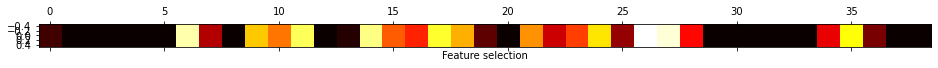

In [21]:
features_eliminated = rfe.ranking_
features_eliminated

#matshow permet d'afficher un array numpy sous la forme d'une matrice
plt.matshow(features_eliminated.reshape(1,-1), cmap = 'hot')
plt.xlabel('Feature selection');

## Test RFE Cross Validation

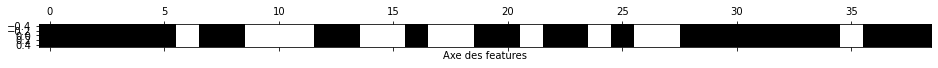

In [22]:
crossval = KFold(n_splits = 5, random_state = 2, shuffle = True)

rfecv = RFECV(estimator = lm, cv = crossval, step = 1)
rfecv.fit(X_train, y_train)

mask = rfecv.get_support()
plt.matshow(mask.reshape(1,-1), cmap = 'gray_r')
plt.xlabel('Axe des features');
plt.show();

Nombre de features retenus : 26


C:\Users\olivier\anaconda\envs\py39\lib\site-packages\sklearn\utils\deprecation.py:103: FutureWarning: The `grid_scores_` attribute is deprecated in version 1.0 in favor of `cv_results_` and will be removed in version 1.2.
  warnings.warn(msg, category=FutureWarning)


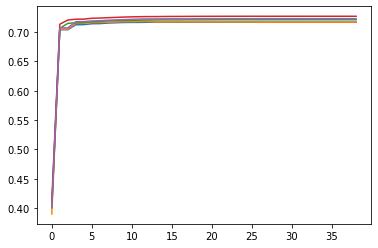

In [23]:
plt.plot(rfecv.grid_scores_);
print("Nombre de features retenus :", rfecv.n_features_)

Il est recommandé de conserver la majorité des features

## Test Régression Lasso

In [24]:
from sklearn.linear_model import Lasso

In [25]:
#lasso_r = Lasso(alpha = 1, max_iter = 5000)
#alpha_grid = {'alpha': list(np.linspace(0.1, 1.0, 10))}
#grid = GridSearchCV(estimator = lasso_r, param_grid = alpha_grid, cv = crossval, scoring = 'neg_mean_squared_error')
#grid.fit(X_train, y_train)
#print(grid.best_params_)

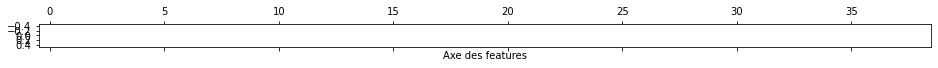

In [26]:
lasso_r = Lasso(alpha = 1)
lasso_r.fit(X_train, y_train)

sel = SelectFromModel(estimator = lasso_r, threshold = 1e-10)
sel.fit(X_train, y_train)

mask = sel.get_support()
plt.matshow(mask.reshape(1,-1), cmap = 'gray_r')
plt.xlabel('Axe des features');
plt.show();

In [27]:
# Afficher les coefficients estimés par le modèle
lasso_r.coef_

array([ 1.51400707e+03,  9.88745473e+04,  6.39945092e+03, -2.48229968e+04,
        3.76573326e+03, -3.48000870e+03, -3.55792028e+01,  1.37716249e+03,
        5.13801002e+03,  3.05904328e+02, -4.06792755e+02, -1.09908394e+02,
        2.01947333e+03, -1.44433673e+03, -7.12168017e+01,  5.79672839e+02,
        7.52729907e+02,  1.39580704e+02,  3.37240239e+02,  1.70706843e+03,
       -1.96355920e+03, -4.31448407e+02,  1.15748589e+03, -6.01693266e+02,
       -1.65834701e+02, -1.61808671e+03,  9.76888371e+00, -3.70955144e+01,
       -6.60042771e+02,  8.31042303e+03,  6.04652217e+03,  5.95018860e+03,
       -3.56604338e+03, -7.25983506e+03, -1.01296479e+03,  1.38779231e+02,
        1.15816206e+03,  2.29794820e+04,  1.31196027e+05])

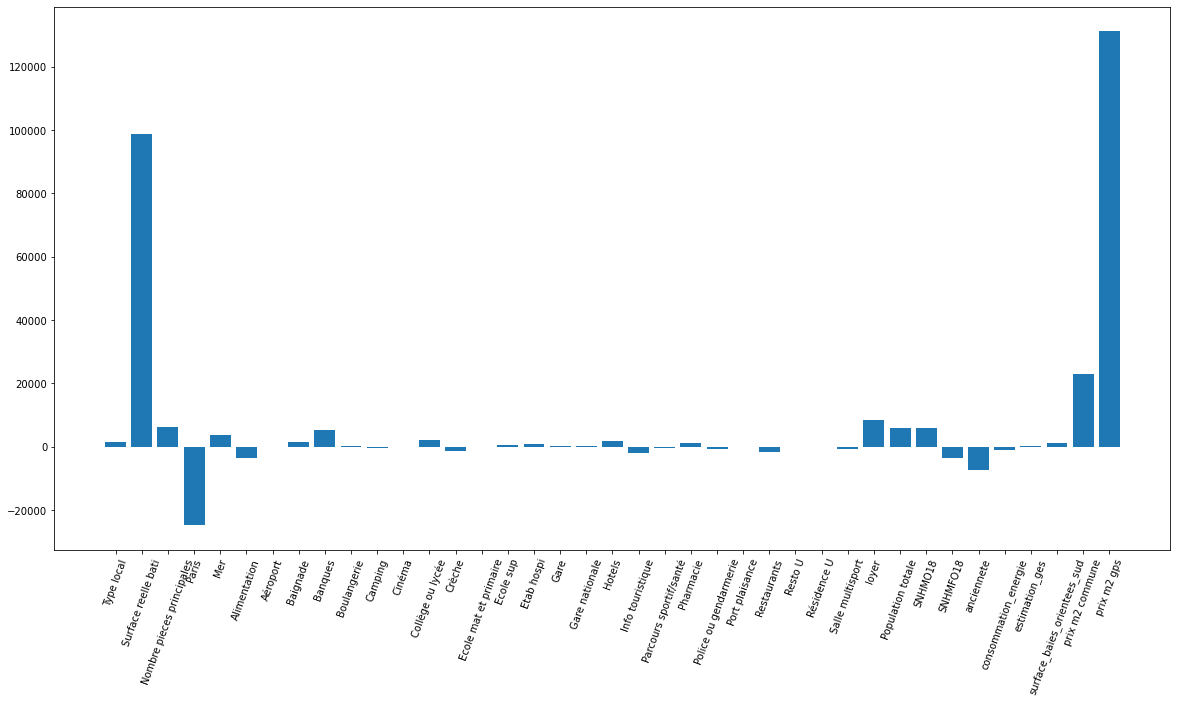

In [28]:
# Afficher un graphique représentant la valeur estimée du coefficient pour chaque variable de data
plt.figure(figsize = (20, 10))

lasso_coef = lasso_r.coef_ 
plt.bar(range(len(df.columns)), lasso_coef) 
plt.xticks(range(len(df.columns)), df.columns.values, rotation=70);

Toutes les features sont conservées.
Les plus importantes semblent être : Surface, prix m² quartier, prix m² commune, revenus Q3 2018, Nb pieces principales, Paris (yes/no)

In [29]:
# Afficher le score (R2) du modèle sur l'ensemble d'apprentissage et l'ensemble de test
print(lasso_r.score(X_train, y_train)) 
print(lasso_r.score(X_test, y_test))

lasso_pred_train = lasso_r.predict(X_train) 
lasso_pred_test = lasso_r.predict(X_test) 
print('rmse train :', mean_squared_error(lasso_pred_train, y_train, squared=False)) 
print('rmse test :', mean_squared_error(lasso_pred_test, y_test, squared=False))

print("mae train : ", mean_absolute_error(lasso_pred_train, y_train))
print('mae test :', mean_absolute_error(lasso_pred_test, y_test))

0.7210236357890059
0.7188282614526671
rmse train : 94885.75398551078
rmse test : 95304.51067258364
mae train :  57490.536194727865
mae test : 57507.38146267799


Dans tous les cas, cela ne fait pas évoluer les scores, ni à la baisse ni à la hausse.
Il sera donc intéressant de ne conserver que les features significatives afin d'accélérer les algos de régression.

## Test Régression RandomForest avant sélection des features importantes

In [30]:
from sklearn.ensemble import RandomForestRegressor
regr = RandomForestRegressor(n_estimators = 50, max_depth = 100, min_samples_leaf = 25, random_state = 123)
regr.fit(X_train,y_train)

rf_pred_train = regr.predict(X_train) 
rf_pred_test = regr.predict(X_test) 

print("score train:",regr.score(X_train, y_train))
print("score test:", regr.score(X_test, y_test))

print("rmse train : ", mean_squared_error(rf_pred_train, y_train, squared=False))
print('rmse test :', mean_squared_error(rf_pred_test, y_test, squared=False))

print("mae train : ", mean_absolute_error(rf_pred_train, y_train))
print('mae test :', mean_absolute_error(rf_pred_test, y_test))

score train: 0.9093496443062125
score test: 0.8898592052677715
rmse train :  54088.1421395067
rmse test : 59648.80200726214
mae train :  32081.37629534417
mae test : 35607.773666238376


## Test Régression RandomForest après sélection des features importantes

In [31]:
df = df[['Surface reelle bati', 'Nombre pieces principales', 'Paris', 'Mer', 'Crèche',
       'Ecole mat et primaire', 'Hotels', 'Info touristique', 'Salle multisport', 'loyer', 
       'SNHMFO18', 'Population totale', 'anciennete', 'Police ou gendarmerie', 'prix m2 commune', 'prix m2 gps']]
df.shape

(198299, 16)

In [32]:
X_train, X_test, y_train, y_test = train_test_split(df, target, test_size = 0.2, random_state = 1234)

In [33]:
from sklearn.ensemble import RandomForestRegressor
regr = RandomForestRegressor(n_estimators = 50, max_depth = 100, min_samples_leaf = 25, random_state = 123)
regr.fit(X_train,y_train)

rf_pred_train = regr.predict(X_train) 
rf_pred_test = regr.predict(X_test) 

print("score train:",regr.score(X_train, y_train))
print("score test:", regr.score(X_test, y_test))

print("rmse train : ", mean_squared_error(rf_pred_train, y_train, squared=False))
print('rmse test :', mean_squared_error(rf_pred_test, y_test, squared=False))

print("mae train : ", mean_absolute_error(rf_pred_train, y_train))
print('mae test :', mean_absolute_error(rf_pred_test, y_test))

score train: 0.9048675384411663
score test: 0.887580409879605
rmse train :  55409.173878659734
rmse test : 60262.704951816944
mae train :  33007.76460620219
mae test : 36102.312774631486


Le score diminue très légèrement et la MAE augmente légèrement lorsqu'on supprime les features estimées superflues par les algos plus haut